# Cosmic Ray Proton Spectrum Fitting
## PAMELA

In [13]:
from pylab import *
from scipy.optimize import minimize 
from scipy import interpolate

In [14]:
def Phi_onebreak(E, K, E0, alpha1, alpha2, omega1, Eb1):
    delta1 = alpha2 - alpha1
    #if omega1 == 0.0: or Eb1 < 1e2 or Eb1 > 1e5:
    #else:
    phi = K * (E/E0)**(-alpha1) * (1 + (E/Eb1)**(1/omega1))**(-delta1 * omega1)
    return phi

In [15]:
Z = 1
m_p = 0.938
data_PAMELA_H = np.genfromtxt("Data/PAMELA_H_data.txt")
R_PAMELA = data_PAMELA_H[:,1]
E_PAMELA = (R_PAMELA * Z) - m_p
flux_R_PAMELA = data_PAMELA_H[:,3]
flux_PAMELA = flux_R_PAMELA / Z
error_PAMELA_stat = data_PAMELA_H[:,4]/Z; error_PAMELA_syst = data_PAMELA_H[:,5]/Z
error_PAMELA = np.sqrt(error_PAMELA_stat**2 + error_PAMELA_syst**2)

In [16]:
E = E_PAMELA
Flux = flux_PAMELA
Sigma = 2*error_PAMELA

# To have the same number of degrees of freedom as in (Lipari & Vernetto, 2019), lower energy must be 8e1 instead of 1e2 GeV
index = np.where(np.logical_and(E>=5e1, E<=1e5))
E = E[index]; Flux = Flux[index]; Sigma = Sigma[index]

# Check number of degrees of freedom
print('# data points used:', 21)
print('# actual data points:', len(Flux))

# Computation of chi^2
def Chi_PAMELA(parameters):
    K, alpha1, alpha2, omega1, Eb1 = parameters
    Phi_model = Phi_onebreak(E, K, 0.1 * 1e3, alpha1, alpha2, omega1, Eb1)
    return sum( (Phi_model - Flux)**2 / Sigma**2 )

# data points used: 21
# actual data points: 21


In [17]:
# Check of chi^2 with reported value
alpha1_bestfit_PAMELA = 2.82
alpha2_bestfit_PAMELA = 2.64
Eb1_bestfit_PAMELA = 0.32 * 1e3 #GeV
omega1_bestfit_PAMELA = 0.28
K_bestfit_PAMELA = 4.60 * 10**(-2) #(GeV m2 s sr)-1

parameters_bestfit_PAMELA = K_bestfit_PAMELA, alpha1_bestfit_PAMELA, alpha2_bestfit_PAMELA, omega1_bestfit_PAMELA, Eb1_bestfit_PAMELA
print('Min chi^2 from Lipari & Vernetto:', 3.3)
print('Computed chi^2:', Chi_PAMELA(parameters_bestfit_PAMELA) )

Min chi^2 from Lipari & Vernetto: 3.3
Computed chi^2: 0.9611309942790983


In [18]:
# Minimization of chi^2 (initial guess = best fit)
#bounds_range = ((4e-2,5e-2),(2,3),(2,3),(0.0001,1),(1e2,1e5))
output = minimize(Chi_PAMELA, (K_bestfit_PAMELA, alpha1_bestfit_PAMELA, alpha2_bestfit_PAMELA, omega1_bestfit_PAMELA, Eb1_bestfit_PAMELA), method='L-BFGS-B')
best_fit_values = output['x']

# Best fit values
print('LIPARI & VERNETTO BEST FIT VALUES:')
print('K:', round(K_bestfit_PAMELA,3)); 
print('alpha_1:', round(alpha1_bestfit_PAMELA,3)); print('alpha_2:', round(alpha2_bestfit_PAMELA,3))
print('omega:', round(omega1_bestfit_PAMELA,3))
print('E_b:', round(Eb1_bestfit_PAMELA,3), 'GeV')
print('')

print('MY BEST FIT VALUES:')
print('K:', round(best_fit_values[0],3))
print('alpha_1:', round(best_fit_values[1],3)); print('alpha_2:', round(best_fit_values[2],3))
print('omega:', round(best_fit_values[3],3))
print('E_b:', round(best_fit_values[4],3), 'GeV')
print('')

min_chi = Chi_PAMELA(best_fit_values)
print('chi^2_min:', round(min_chi,7))

LIPARI & VERNETTO BEST FIT VALUES:
K: 0.046
alpha_1: 2.82
alpha_2: 2.64
omega: 0.28
E_b: 320.0 GeV

MY BEST FIT VALUES:
K: 0.046
alpha_1: 2.817
alpha_2: 2.639
omega: 0.104
E_b: 320.0 GeV

chi^2_min: 0.8202406


In [19]:
def Errors_PAMELA(n):
    
    alpha1 = 2.82
    alpha2 = 2.64
    Eb1 = 0.32 * 1e3 #GeV
    omega1 = 0.28
    K = 4.60 * 10**(-2) #(GeV m2 s sr)-1
    bounds_range = ((4e-2,5e-2),(2,3),(2,3),(0.0001,1),(1e2,1e5))
    output = minimize(Chi_PAMELA, (K, alpha1, alpha2, omega1, Eb1), method='L-BFGS-B', bounds=bounds_range)
    best_fit_values = output['x']
    
    scan = np.zeros(50)
    fit = best_fit_values[n]
    for i in range(0, 25):
        scan[i] = fit - (fit / 100)*i
    for j in range(25, 50):
        scan[j] = fit + (fit / 100)*j
    scan = np.sort(scan)
    
    true_best_fit = Chi_PAMELA(best_fit_values)
    chi_sqrd = np.zeros(50)
    for k in range(0, 50):
        best_fit_values[n] = scan[k]
        scan_chi = Chi_PAMELA(best_fit_values)
        chi_sqrd[k] = np.abs(true_best_fit - scan_chi)
    return scan, fit, chi_sqrd

# Find value for which chi^2 is equal to one
yToFind = 5.89

# Error of normilization
scan, fit, chi_sqrd = Errors_PAMELA(0)
yreduced = np.array(chi_sqrd) - yToFind
freduced = interpolate.UnivariateSpline(scan, yreduced, s=0)
scan_interval = freduced.roots()
print('K'); print('Lower error:', fit - scan_interval[0]); print('Upper error:', scan_interval[1] - fit)

# Error of first index
scan, fit, chi_sqrd = Errors_PAMELA(1)
yreduced = np.array(chi_sqrd) - yToFind
freduced = interpolate.UnivariateSpline(scan, yreduced, s=0)
scan_interval = freduced.roots()
print('alpha1'); print('Lower error:', fit - scan_interval[0]); print('Upper error:', scan_interval[1] - fit)

#Error of second index
scan, fit, chi_sqrd = Errors_PAMELA(2)
yreduced = np.array(chi_sqrd) - yToFind
freduced = interpolate.UnivariateSpline(scan, yreduced, s=0)
scan_interval = freduced.roots()
print('alpha2'); print('Lower error:', fit - scan_interval[0]); print('Upper error:', scan_interval[1] - fit)

K
Lower error: 0.0021737572284018444
Upper error: 0.0022218609782224327
alpha1
Lower error: 0.07571362089228995
Upper error: 0.09661833117271135
alpha2
Lower error: 0.2725309836680565
Upper error: 0.3684392044032463


/var/folders/j4/1fvnmc755y74k9kgn5w7_s400000gn/T/ipykernel_3011/3564882007.py:5: RuntimeWarning: overflow encountered in power
  phi = K * (E/E0)**(-alpha1) * (1 + (E/Eb1)**(1/omega1))**(-delta1 * omega1)


Eb1
Lower error: 152.89531890199018


/var/folders/j4/1fvnmc755y74k9kgn5w7_s400000gn/T/ipykernel_3011/3564882007.py:5: RuntimeWarning: overflow encountered in power
  phi = K * (E/E0)**(-alpha1) * (1 + (E/Eb1)**(1/omega1))**(-delta1 * omega1)


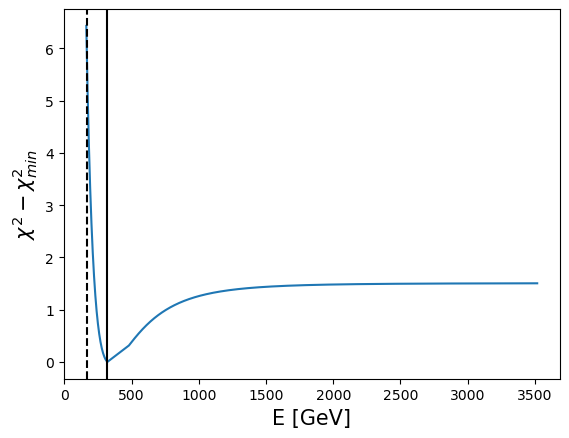

In [23]:
def Errors_PAMELA(n):
    
    alpha1 = 2.82
    alpha2 = 2.64
    Eb1 = 0.32 * 1e3 #GeV
    omega1 = 0.28
    K = 4.60 * 10**(-2) #(GeV m2 s sr)-1
    bounds_range = ((4e-2,5e-2),(2,3),(2,3),(0.0001,1),(1e2,1e5))
    output = minimize(Chi_PAMELA, (K, alpha1, alpha2, omega1, Eb1), method='L-BFGS-B', bounds=bounds_range)
    best_fit_values = output['x']
    
    scan = np.zeros(1000)
    fit = best_fit_values[n]
    for i in range(0, 50):
        scan[i] = fit - (fit / 100)*i
    for j in range(50, 1000):
        scan[j] = fit + (fit / 100)*j
    scan = np.sort(scan)
    
    true_best_fit = Chi_PAMELA(best_fit_values)
    chi_sqrd = np.zeros(1000)
    for k in range(0, 1000):
        best_fit_values[n] = scan[k]
        scan_chi = Chi_PAMELA(best_fit_values)
        chi_sqrd[k] = np.abs(true_best_fit - scan_chi)
    return scan, fit, chi_sqrd

# Error of break energy
scan, fit, chi_sqrd = Errors_PAMELA(4)
yreduced = np.array(chi_sqrd) - yToFind
freduced = interpolate.UnivariateSpline(scan, yreduced, s=0)
scan_interval = freduced.roots()
print('Eb1'); print('Lower error:', fit - scan_interval[0])

# Check chi^2 - chi^2_min distribution
plt.plot(scan, chi_sqrd)
plt.xlabel('E [GeV]', fontsize=15)
plt.ylabel(r'$\chi^2 - \chi^2_{min}$', fontsize=15)
plt.axvline(x = fit, color='black')
plt.axvline(x = scan_interval[0], linestyle='--', color='black')

omega1
Upper error: 0.5802542306579759


/var/folders/j4/1fvnmc755y74k9kgn5w7_s400000gn/T/ipykernel_3011/3564882007.py:5: RuntimeWarning: overflow encountered in power
  phi = K * (E/E0)**(-alpha1) * (1 + (E/Eb1)**(1/omega1))**(-delta1 * omega1)


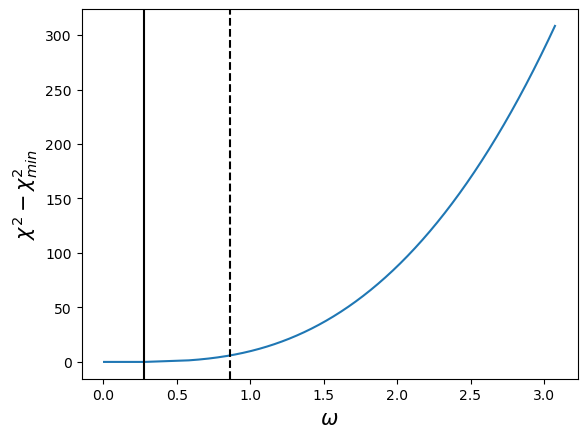

In [21]:
def Errors_PAMELA(n):
    
    alpha1 = 2.82
    alpha2 = 2.64
    Eb1 = 0.32 * 1e3 #GeV
    omega1 = 0.28
    K = 4.60 * 10**(-2) #(GeV m2 s sr)-1
    bounds_range = ((4e-2,5e-2),(2,3),(2,3),(0.0001,1),(1e2,1e5))
    output = minimize(Chi_PAMELA, (K, alpha1, alpha2, omega1, Eb1), method='L-BFGS-B', bounds=bounds_range)
    best_fit_values = output['x']
    
    scan = np.zeros(500)
    fit = best_fit_values[n]
    for i in range(0, 50):
        scan[i] = fit - (fit / 50)*i
    for j in range(50, 500):
        scan[j] = fit + (fit / 50)*j
    scan = np.sort(scan)
    
    true_best_fit = Chi_PAMELA(best_fit_values)
    chi_sqrd = np.zeros(500)
    for k in range(0, 500):
        best_fit_values[n] = scan[k]
        scan_chi = Chi_PAMELA(best_fit_values)
        chi_sqrd[k] = np.abs(true_best_fit - scan_chi)
    return scan, fit, chi_sqrd

# Error of width
scan, fit, chi_sqrd = Errors_PAMELA(3)
yreduced = np.array(chi_sqrd) - yToFind
freduced = interpolate.UnivariateSpline(scan, yreduced, s=0)
scan_interval = freduced.roots()
print('omega1'); print('Upper error:', scan_interval[0] - fit)

# Check chi^2 - chi^2_min distribution
plt.plot(scan, chi_sqrd)
plt.xlabel(r'$\omega$', fontsize=15)
plt.ylabel(r'$\chi^2 - \chi^2_{min}$', fontsize=15)
plt.axvline(x = fit, color='black')
plt.axvline(x = scan_interval[0], linestyle='--', color='black')

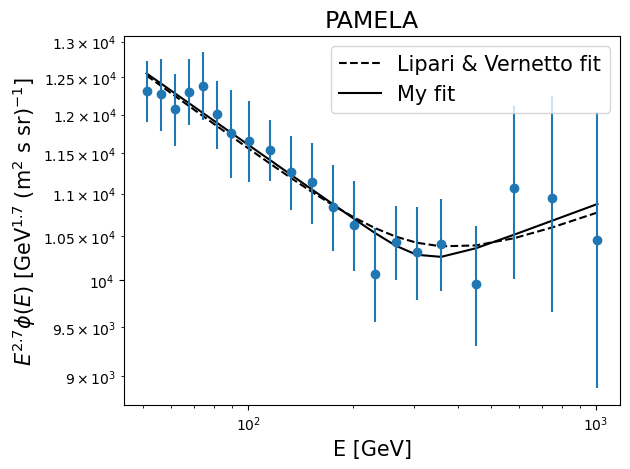

In [22]:
# Lipari & Vernetto
Phi_model = Phi_onebreak(E, K_bestfit_PAMELA, 0.1 * 1e3, alpha1_bestfit_PAMELA, alpha2_bestfit_PAMELA, omega1_bestfit_PAMELA, Eb1_bestfit_PAMELA)
# Me
Phi_fit = Phi_onebreak(E, best_fit_values[0], 0.1 * 1e3, best_fit_values[1], best_fit_values[2], best_fit_values[3], best_fit_values[4])

plt.figure()
plt.plot(E, Phi_model * E**2.7, linestyle='--', color='black', label='Lipari & Vernetto fit')
plt.plot(E, Phi_fit * E**2.7, color='black', label='My fit')
plt.errorbar(E_PAMELA[index], flux_PAMELA[index] * E_PAMELA[index]**2.7, yerr=error_PAMELA[index] * E_PAMELA[index]**2.7, fmt='o')
plt.loglog()
plt.ylabel(r'$E^{2.7}\phi(E)$ [GeV$^{1.7}$ (m$^2$ s sr)$^{-1}$]', fontsize=15)
plt.xlabel('E [GeV]', fontsize=15)
plt.title('PAMELA', fontsize=17)
plt.legend(fontsize=15)
plt.savefig('Fits/PAMELA_fit.png')